# denoising_20211111
Taking ideas from [this Bryan Arnold notebook](https://www.kaggle.com/puremath86/label-correction-experiments-tps-nov-21), which does a few cool things but mainly attempts denoising the labels with `cleanlab`. Also, trying `rank_gauss_scaler`

In [1]:
# notebook configuration
COLAB = False # will trigger manual installation of packages
USE_GPU = True 

In [2]:
# basic imports
from pathlib import Path
import os
import math
from datetime import datetime
import random
import datatable as dt
import gc; gc.enable()

- `gc` is the garbage collection interface in Python; he uses it to optimize memory utilization, in tandem with `del` statements.

In [3]:
%matplotlib inline
%config Completer.use_jedi = False
os.environ['WANDB_NOTEBOOK_NAME'] = f"nb_{datetime.now().strftime('%Y%m%d')}.ipynb"

Now, non-stdlib imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# general ML tooling
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import log_loss, roc_auc_score
import wandb
from wandb.xgboost import wandb_callback
from wandb.lightgbm import wandb_callback
from sklearn.impute import SimpleImputer #, KNNImputer

import seaborn as sns

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.preprocessing import RobustScaler #StandardScaler #, MinMaxScaler, MaxAbsScaler, RobustScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
# from sklearn.feature_selection import SelectKBest, f_regression
from joblib import dump, load
# feature engineering tools
# from sklearn.feature_selection import mutual_info_regression
# import featuretools as ft
from gauss_rank_scaler import GaussRankScaler


# from BorutaShap import BorutaShap

In [5]:
# from pytorch_widedeep import Trainer
# from pytorch_widedeep.preprocessing import WidePreprocessor, TabPreprocessor
# from pytorch_widedeep.models import Wide, TabMlp, WideDeep#, SAINT, TabTransformer, TabNet, TabFastFormer, TabResnet
# from pytorch_widedeep.metrics import Accuracy
# from torchmetrics import AUROC
# import torch
# from torch.optim import Adam, AdamW, Adagrad, SGD, RMSprop, LBFGS
# from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts, CyclicLR, OneCycleLR, StepLR, CosineAnnealingLR
# from pytorch_widedeep.callbacks import EarlyStopping, LRHistory, ModelCheckpoint

Now, datapath setup

In [6]:
if COLAB:
    # mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    
    # handling datapath
    datapath = Path('/content/drive/MyDrive/kaggle/tabular_playgrounds/nov2021/')
    
else:
    # if on local machine
#     datapath = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/sep2021/')  
    root = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/nov2021/')
    datapath = root/'datasets'
    # edapath = root/'EDA'
    # modelpath = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/oct2021/models/')
    predpath = root/'preds'
    subpath = root/'submissions'
    
    for pth in [datapath, predpath, subpath]:
        pth.mkdir(exist_ok=True)
    


In [7]:
SEED = 42

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(seed=SEED)

The following function is used to optimize dataset memory utilization in RAM

In [8]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

- Basically, you start by creating a list of the numeric types you may be using, and initializing the memory utilization (so you can see at the end how much you've saved). 
- Then, you iterate over the columns (`for col in df.columns:`) and check if the column's [[data type]] is numeric; if it is, then you store the minimum and maximum values for the column (since one of them is guaranteed to be the biggest memory-hog of the bunch, though which depends on the feature's range). 
- Then, you start going through a series of case statements, deciding whether the datatype is an integer or not, and then proceeding through the different [[NumPy]] integer or float types in increasing size, [[typecasting]] when you come to the first size that will accommodate both the max and min value from the column. (*Note here that `np.iinfo(np.int64).min` et al will apparently return a value rather than an absolute size in bits, which is fine.*)
- Then, you find out what the final memory size is, and print out how big of a savings you've obtained.

In [41]:
# dataset_params will initially include either trivial class instances or loaded, precomputed artifacts
dataset_params = {
    'train_source': datapath/'X_orig.feather',
    'target_source': datapath/'y_orig.joblib',
    # 'test_source': str(datapath/'X_test-RobustScaled-pca_mle-umap_embedding_20211107-n_comp10-n_neighbors15-rs42.joblib'),
    # 'scaler': str(RobustScaler()),
    # 'pca': str(load(datapath/'pca_mle-RobustScaled_orig_trainset.joblib')),
    # 'umap': str(load(datapath/'umap_reducer-20211107-n_comp10-n_neighbors15-rs42-pca_mle-RobustScaled_orig_trainset.joblib')),
}   

# referring back to the already-entered attributes, specify how the pipeline was sequenced
# dataset_params['preprocessing_pipeline'] = str([dataset_params['scaler'], dataset_params['pca'], dataset_params['umap']]) # ACTUALLY this is unwieldy
# dataset_params['preprocessing_pipeline'] = '[scaler, pca, umap]' # more fragile, but also more readable

# now, load the datasets and generate more metadata from them
X = pd.read_feather(dataset_params['train_source'])
y = load(dataset_params['target_source'])
# X_test = load(dataset_params['test_source'])

dataset_params['feature_count'] = X.shape[1]
dataset_params['instance_count'] = X.shape[0]
    

In [10]:
X_light = reduce_memory_usage(X)

Mem. usage decreased to 114.44 Mb (75.0% reduction)


In [12]:
X_light.shape

(600000, 100)

In [13]:
X_base = X_light
del X_light
gc.collect()

34

In [15]:
?gc.collect

Signature: gc.collect(generation=2)
Docstring:
Run the garbage collector.

With no arguments, run a full collection.  The optional argument
may be an integer specifying which generation to collect.  A ValueError
is raised if the generation number is invalid.

The number of unreachable objects is returned.
Type:      builtin_function_or_method


In [16]:
X_base.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
0,0.106628,3.593750,132.7500,3.183594,0.081970,1.188477,3.732422,2.265625,2.099609,0.012329,...,0.010742,1.098633,0.013329,-0.011719,0.052765,0.065430,4.210938,1.978516,0.085999,0.240479
1,0.125000,1.673828,76.5625,3.378906,0.099426,5.093750,1.275391,-0.471436,4.546875,0.037720,...,0.135864,3.460938,0.017059,0.124878,0.154053,0.606934,-0.267822,2.578125,-0.020874,0.024719
2,0.036316,1.497070,233.5000,2.195312,0.026917,3.126953,5.058594,3.849609,1.801758,0.057007,...,0.117310,4.882812,0.085205,0.032410,0.116089,-0.001689,-0.520020,2.140625,0.124451,0.148193
3,-0.014076,0.245972,780.0000,1.890625,0.006947,1.531250,2.697266,4.515625,4.503906,0.123474,...,-0.015350,3.474609,-0.017105,-0.008102,0.062012,0.041199,0.511719,1.968750,0.040009,0.044861
4,-0.003260,3.714844,156.1250,2.148438,0.018280,2.097656,4.156250,-0.038239,3.371094,0.034180,...,0.013779,1.910156,-0.042938,0.105591,0.125122,0.037506,1.043945,1.075195,-0.012817,0.072815


# RankGauss, Other Transforms

In [17]:
scaler = GaussRankScaler()
X_gauss = scaler.fit_transform(X)

In [18]:
X_gauss = pd.DataFrame(X_gauss, columns=X_base.columns)

In [19]:
X_gauss.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
0,0.503864,1.170148,0.497627,1.061322,0.497063,0.697261,1.178046,0.918892,0.898030,0.264610,...,0.313791,0.697968,0.228935,-0.745756,0.410898,0.511767,1.301817,0.886265,0.491337,0.715292
1,0.532606,0.817177,0.414955,1.099940,0.523378,1.430099,0.707201,-1.001742,1.361183,0.395362,...,0.712643,1.133297,0.258559,0.941823,0.550487,0.937882,-0.799881,0.975537,-0.595291,0.375001
2,0.364383,0.777697,0.581712,0.902238,0.358373,1.046707,1.450572,1.213861,0.833888,0.448396,...,0.684576,1.420673,0.444982,0.597667,0.514780,-0.345367,-1.076664,0.911155,0.547897,0.627946
3,-0.552709,0.361766,0.800397,0.847488,0.205250,0.767239,0.975344,1.338971,1.352906,0.554931,...,-0.698743,1.136185,-0.622266,-0.671410,0.436283,0.439042,0.506585,0.883681,0.397615,0.451311
4,-0.357576,1.199284,0.516476,0.895768,0.313432,0.890002,1.273778,-0.348193,1.110106,0.385873,...,0.349392,0.873186,-0.772866,0.873466,0.528289,0.427691,0.679960,0.684102,-0.528382,0.520949


array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>,
        <AxesSubplot:title={'center':'f2'}>],
       [<AxesSubplot:title={'center':'f3'}>,
        <AxesSubplot:title={'center':'f4'}>,
        <AxesSubplot:title={'center':'f5'}>],
       [<AxesSubplot:title={'center':'f6'}>,
        <AxesSubplot:title={'center':'f7'}>,
        <AxesSubplot:title={'center':'f8'}>],
       [<AxesSubplot:title={'center':'f9'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

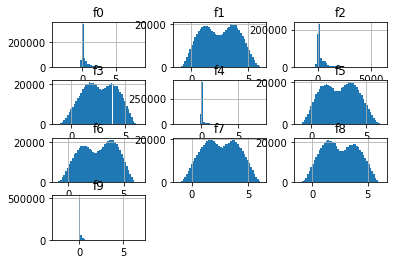

In [25]:
X_base.iloc[:, :10].hist(bins=50)

array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>,
        <AxesSubplot:title={'center':'f2'}>],
       [<AxesSubplot:title={'center':'f3'}>,
        <AxesSubplot:title={'center':'f4'}>,
        <AxesSubplot:title={'center':'f5'}>],
       [<AxesSubplot:title={'center':'f6'}>,
        <AxesSubplot:title={'center':'f7'}>,
        <AxesSubplot:title={'center':'f8'}>],
       [<AxesSubplot:title={'center':'f9'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

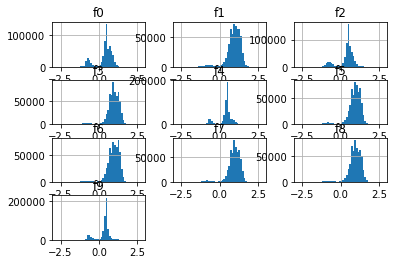

In [26]:
X_gauss.iloc[:, :10].hist(bins=50)

In [28]:
robust_scaler = RobustScaler()
X_robust = robust_scaler.fit_transform(X_base)
X_robust = pd.DataFrame(X_robust, columns=X_base.columns)
X_robust.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
0,0.023849,0.414551,-0.003382,0.222534,0.219116,-0.548828,0.356934,-0.117676,-0.150024,-0.569336,...,-0.615723,-0.519531,-0.523438,-1.074219,-0.110901,0.042664,0.625488,-0.282227,0.287598,2.097656
1,0.073364,-0.323730,-0.220581,0.301758,0.406738,0.980469,-0.584473,-1.216797,0.823730,-0.258057,...,1.143555,0.433350,-0.488037,1.072266,0.943848,7.121094,-1.115234,-0.041534,-0.812012,-0.389160
2,-0.165649,-0.391602,0.385986,-0.178223,-0.372803,0.210327,0.864746,0.518555,-0.268555,-0.021347,...,0.882324,1.006836,0.153442,-0.380615,0.548340,-0.834473,-1.212891,-0.217041,0.683105,1.034180
3,-0.301514,-0.872559,2.500000,-0.301758,-0.587402,-0.414551,-0.039642,0.785645,0.806641,0.793945,...,-0.982422,0.438721,-0.809570,-1.017578,-0.014618,-0.273926,-0.812500,-0.286133,-0.185547,-0.156860
4,-0.272217,0.461182,0.086975,-0.197266,-0.465576,-0.192749,0.519043,-1.042969,0.355957,-0.301270,...,-0.573242,-0.192261,-1.052734,0.769043,0.642578,-0.322266,-0.605469,-0.644531,-0.729004,0.165405


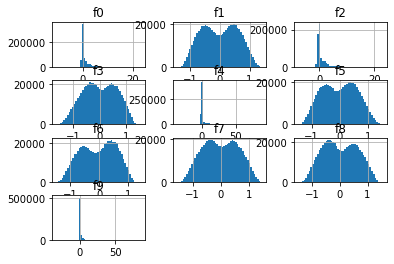

In [30]:
X_robust.iloc[:, :10].hist(bins=50);

In [31]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

In [34]:
del X_base

In [36]:
del X_robust

In [37]:
gc.collect()

0

In [42]:
X.dtypes

f0     float64
f1     float64
f2     float64
f3     float64
f4     float64
        ...   
f95    float64
f96    float64
f97    float64
f98    float64
f99    float64
Length: 100, dtype: object

In [43]:
power_transform = PowerTransformer()
X_power = power_transform.fit_transform(X)
X_power = pd.DataFrame(X_power, columns=X.columns)
X_power.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
0,-0.330764,0.720239,-0.185486,0.362574,-0.156842,-0.853394,0.667399,-0.160510,-0.234598,-0.357589,...,-0.565506,-0.847819,-0.307379,-0.927254,-0.194510,-0.098997,1.055397,-0.388207,-0.105342,0.724264
1,-0.272488,-0.486992,-0.313108,0.485275,-0.087189,1.558091,-0.899712,-2.103362,1.270651,-0.229298,...,0.641452,0.676891,-0.297071,0.867816,0.251454,2.603714,-1.911892,0.004260,-0.532986,-0.400761
2,-0.567016,-0.604689,0.020900,-0.272131,-0.388096,0.395922,1.479006,0.828781,-0.432729,-0.135055,...,0.468604,1.513583,-0.111917,-0.323559,0.091440,-0.786038,-2.114633,-0.281473,0.036836,0.283660
3,-0.750805,-1.499700,0.958682,-0.470166,-0.476486,-0.621742,0.019516,1.230873,1.245859,0.170004,...,-0.829848,0.685489,-0.392448,-0.876844,-0.151133,-0.331031,-1.324488,-0.394903,-0.282993,-0.280477
4,-0.710261,0.792576,-0.135717,-0.302424,-0.425993,-0.249634,0.928278,-1.759618,0.571015,-0.246894,...,-0.534985,-0.297603,-0.465794,0.627528,0.130013,-0.367829,-0.951063,-0.988675,-0.498888,-0.119675


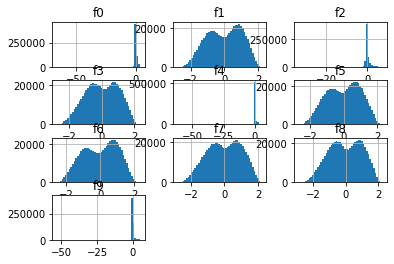

In [44]:
X_power.iloc[:, :10].hist(bins=50);

# cleanlab